# Vehicle Detection Project

This is project 5 of the Self-Driving Car Nanodegree, Vehicle Detection.

## Loading data

In this section, we load the training data (vehicles vs. non-vehicles) and display a sample of each.

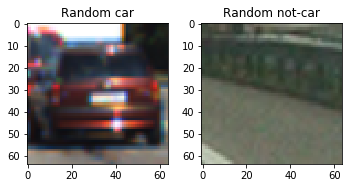

In [65]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
%matplotlib inline

with open('training_images/vehicles.txt') as file:
    cars = [car.strip() for car in file.readlines()]

with open('training_images/non-vehicles.txt') as file:
    notcars = [notcar.strip() for notcar in file.readlines()]

fig = plt.figure(figsize=(5,5))
plt.subplot(121)
plt.imshow(mpimg.imread(random.sample(cars, 1)[0]))
plt.title('Random car')
plt.subplot(122)
plt.imshow(mpimg.imread(random.sample(notcars, 1)[0]))
plt.title('Random not-car')
fig.tight_layout()
_ = plt.savefig("output_images/car-notcar.png", format="png")

## Train Classifier

In this section, we extract features from the images and train a SVM classifier. Most of this code was taken from the course materials and exercises. The parameters for feature extraction were optimized in the "Search and Classify" section of the vehicle detection lesson.

In [66]:
from skimage.feature import hog

color_spaces = {
    'HSV': cv2.COLOR_RGB2HSV,
    'LUV': cv2.COLOR_RGB2LUV,
    'HLS': cv2.COLOR_RGB2HLS,
    'YUV': cv2.COLOR_RGB2YUV,
    'YCrCb': cv2.COLOR_RGB2YCrCb
}

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# bins_range is 0 to 1 because all input values are 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = cv2.cvtColor(image, color_spaces[color_space])
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                for channel in range(feature_image.shape[2]):
                    file_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False).ravel())
            else:
                file_features.append(get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=False).ravel())
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


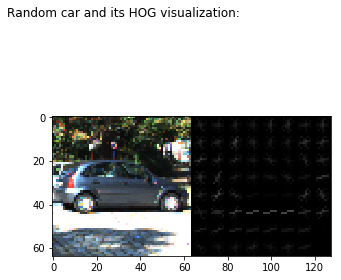

In [68]:
# Define parameters for feature extraction in order to train the classifier
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (48, 48) # Spatial binning dimensions
hist_bins = 48    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Show a sample of a car and its HOG feature extraction - use only one channel for example,
# though we can use all channels for actual prediction.
img = mpimg.imread(random.sample(cars, 1)[0])
_, vis = get_hog_features(cv2.cvtColor(img, color_spaces[color_space])[:,:,0], orient, pix_per_cell, cell_per_block, vis=True)
comb_img = np.concatenate((img, np.dstack((vis, vis, vis))), axis=1)
plt.figure(figsize=(5,5))
plt.suptitle("Random car and its HOG visualization:", x=0, y=1, horizontalalignment="left")
_ = plt.imshow(comb_img)
mpimg.imsave('output_images/hog_car.png', comb_img)

In [12]:
from sklearn.preprocessing import StandardScaler

# Get features and labels for training the classifier

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print("Got", len(X), "features/labels")

Got 17760 features/labels


In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Train the classifier
clf = LinearSVC()
clf.fit(X_train, y_train)
# Check the score of the classifier
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 12348
Test Accuracy of classifier =  0.9899


## Sliding Window Search

In this section, we search an image using sliding windows of decreasing sizes, using the classifier to detect cars. Again, most of this code was taken or adapted from class materials and exercises. We compute the HOG array for the entire image, and then transform each window into a feature vector. We expect multiple detections and false positives, which we will filter out later using heat maps (and, in the pipeline, heat maps over multiple frames). We also expect false negatives, which we'll make up for by using detections from multiple frames, though we can't see this too well in static images. The trick is to get the cars to have a significantly higher density of detections than the not-car areas.

In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single window rather than list of images
# This takes a subimage that's been converted to the desired color space
# and does *not* extract HOG features as that's only done once per larger
# image
def single_img_features(img, spatial_size=(32, 32), hist_bins=32, spatial_feat=True, hist_feat=True):    
    # Define an empty list to receive features
    img_features = [[]]
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(img, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(img, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)

    # Return raveled array of features
    return np.concatenate(img_features)

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Find all cars in an image, getting image-wide HOG features only once per window size
# We get most parameters from global variables defined above in the third code cell
def find_cars(img, ystart, ystop, window_sizes=[64], overlap=0.5):
    # Convert the image to the same format as the PNG image - 0-1 scale
    img = img.astype(np.float32)/255
    
    if color_space != 'RGB':
        img = cv2.cvtColor(img, color_spaces[color_space])
    
    bboxes = []

    # Slide multiple sizes of windows for running through the classifier
    for window_size in window_sizes:
        # Resize image so that a 64x64 window is equivalent to the desired window size,
        # as 64x64 is the image size with which we trained the classifier
        scale = window_size/64
        res_img = cv2.resize(img, (int(img.shape[1]/scale), int(img.shape[0]/scale)))

        # Call get_hog_features() with vis=False, feature_vec=False for the appropriate
        # channels
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(res_img.shape[2]):
                hog_features.append(get_hog_features(res_img[:,:,channel], orient,
                    pix_per_cell, cell_per_block, vis=False, feature_vec=False))
        else:
            hog_features = get_hog_features(res_img[:,:,hog_channel], orient, 
                pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
        
        # Find 64x64 windows in the resized image
        y_start_stop=[int(ystart/scale), int(ystop/scale)]
        windows = slide_window(res_img, y_start_stop=y_start_stop,
                       xy_window=(64, 64), xy_overlap=(overlap, overlap))

        # Iterate through windows, extracting features and running them through the classifier
        for window in windows:
            startx, starty, stopx, stopy = window[0][0], window[0][1], window[1][0], window[1][1]
            # Get the non-HOG features first (same order as used to train classifier)
            features = single_img_features(res_img[starty:stopy,startx:stopx,:], spatial_size=spatial_size,
                hist_bins=hist_bins, spatial_feat=spatial_feat, hist_feat=hist_feat)
            # Get the HOG features for the window
            if hog_feat == True:
                if hog_channel == 'ALL':
                    for channel in range(res_img.shape[2]):
                        features = np.concatenate((features,
                                            hog_features[channel][
                                                         starty // pix_per_cell:(stopy // pix_per_cell) - 1,
                                                         startx // pix_per_cell:(stopx // pix_per_cell) - 1,
                                                         :].ravel()))
                else:
                    features = np.concatenate((features,
                                        hog_features[
                                                     starty // pix_per_cell:(stopy // pix_per_cell) - 1,
                                                     startx // pix_per_cell:(stopx // pix_per_cell) - 1,
                                                     :].ravel()))
            # Scale features and make a prediction
            features = features.reshape(1, -1)
            features = X_scaler.transform(features)
            prediction = clf.predict(features)
            
            if prediction == 1:
                xbox_left = np.int(startx*scale)
                ytop_draw = np.int(starty*scale)
                bboxes.append(((xbox_left, ytop_draw),(xbox_left+window_size,ytop_draw+window_size)))
                
    return bboxes

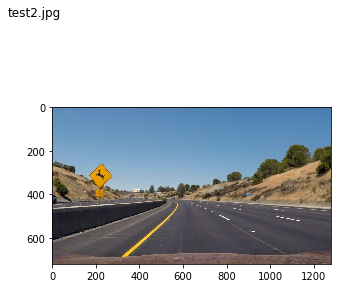

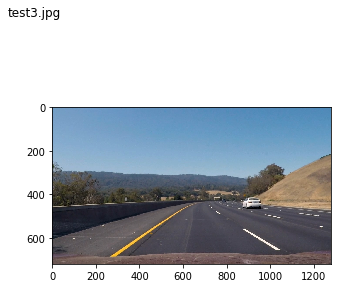

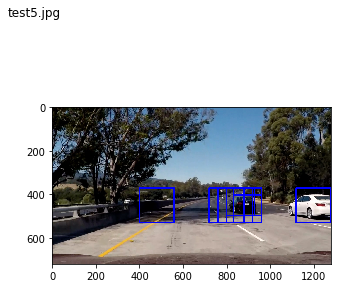

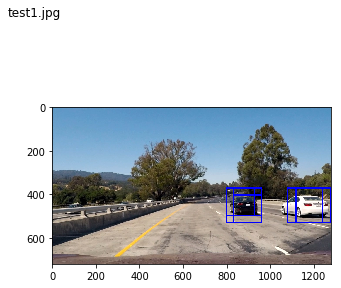

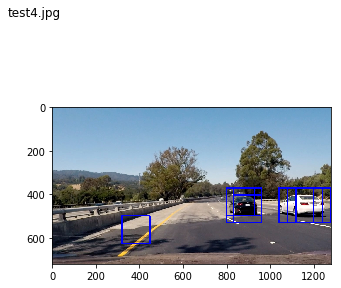

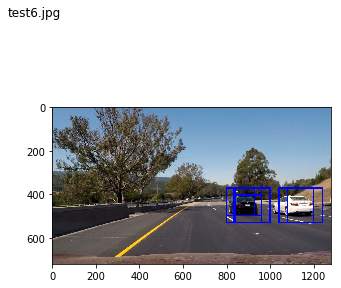

In [69]:
import glob

# Define sliding window search parameters
y_start = 370
y_stop = 720
win_size_overlaps=[[[160, 128], 0.75]]

# Process test images
for image in glob.glob('test_images/*.jpg'):
    img = mpimg.imread(image)
    image = image[image.rfind('/')+1:]
    bboxes = []
    for wo in win_size_overlaps:
        bboxes.extend(find_cars(img, y_start, y_stop, window_sizes=wo[0], overlap=wo[1]))
    det_img = draw_boxes(img, bboxes)
    plt.figure(figsize=(5,5))
    plt.suptitle(image, x=0, y=1, horizontalalignment="left")
    _ = plt.imshow(det_img)
    image = image.replace('.jpg', '_windows.jpg')
    mpimg.imsave('output_images/' + image, det_img, format='jpg')

## Heat Maps

In this section, we apply a heat map to detected windows to help eliminate false positives and multiple detections. Again, much of this code is taken from class materials and exercises, and again, we don't expect to eliminate all false positives/multiple detections, and it doesn't help with false negatives unless tracked over a series of frames.

In [70]:
# Add heat for all of the bbox windows
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Threshold pixels to a minimum heat
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Draw bounding boxes based on labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



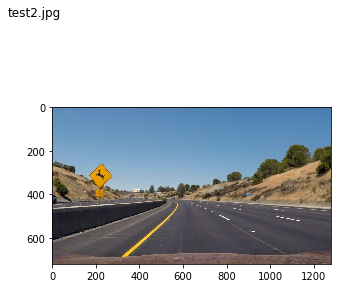

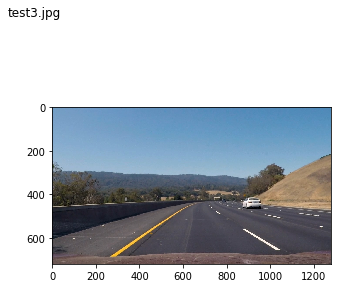

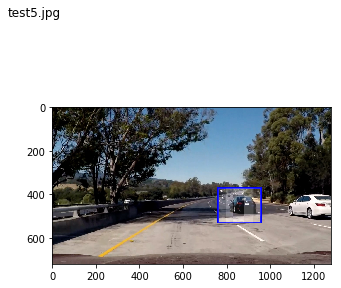

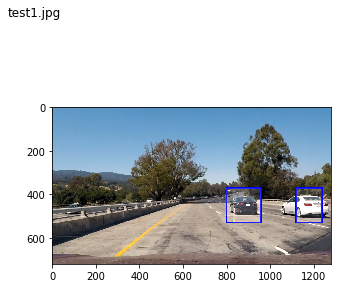

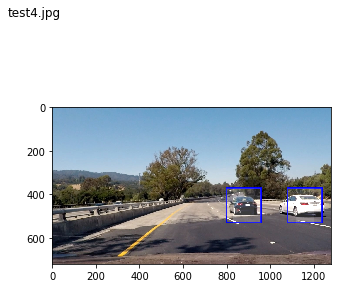

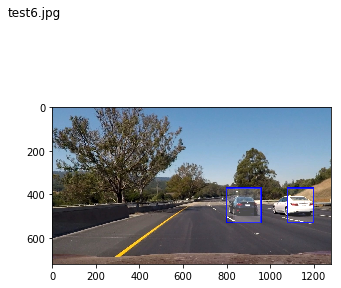

In [71]:
from scipy.ndimage.measurements import label

# This setting eliminates false positives but also causes false negatives
# on single frames. Tracking the heat map across multiple frames works much
# better.
heat_threshold = 1

# Process test images
for image in glob.glob('test_images/*.jpg'):
    img = mpimg.imread(image)
    image = image[image.rfind('/')+1:]
    bboxes = []
    for wo in win_size_overlaps:
        bboxes.extend(find_cars(img, y_start, y_stop, window_sizes=wo[0], overlap=wo[1]))
    heat = np.zeros_like(img[:,:,0]).astype(np.uint8)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, heat_threshold)
    labels = label(heat)
    heat = np.dstack((heat, heat, heat)) * 50 # For easy visualization
    det_img = draw_labeled_bboxes(img, labels)
    det_img = cv2.addWeighted(det_img, 1, heat, 0.3, 0)
    plt.figure(figsize=(5,5))
    plt.suptitle(image, x=0, y=1, horizontalalignment="left")
    _ = plt.imshow(det_img)
    image = image.replace('.jpg', '_heat_labeled_windows.jpg')
    mpimg.imsave('output_images/' + image, det_img, format='jpg')

## Pipeline

This section creates the pipeline and uses it to process the project video. Working with a video lets us threshold heat maps across multiple frames, which gives us more accuracy. This is reflected in the output video when compared to the heat maps generated above..

In [72]:
# Create the pipeline for video processing

# Number of frames over which to average heat maps
# (vehicles earlier than this number of frames may not be detected)
heat_frames=10

# Heat map threshold applied to the number of frames
video_heat_threshold = 2

# Initialize the lookback list
heat_lookback = []

# The video pipeline gets its settings from global variables defined above (in this code
# cell and previous ones)
def pipeline(img):
    # Since we're writing to heat_lookback, we need to declare it as a global
    global heat_lookback
    # Get preliminary bounding boxes
    bboxes = []
    for wo in win_size_overlaps:
        bboxes.extend(find_cars(img, y_start, y_stop, window_sizes=wo[0], overlap=wo[1]))
    # Append this frame's bboxes to the lookback buffer
    heat_lookback.append(bboxes)
    # Remove first frame's bboxes from buffer if buffer's full
    if len(heat_lookback) > heat_frames:
        heat_lookback = heat_lookback[1:]
    heat = np.zeros_like(img[:,:,0]).astype(np.uint8)
    # Add heat for previous frames
    for bb in heat_lookback:
        heat = add_heat(heat, bb)
    # Threshold heat
    heat = apply_threshold(heat, video_heat_threshold)
    # Apply labels, draw them, and return the result
    return draw_labeled_bboxes(img, label(heat))

In [73]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Reinitialize the lookback list to make sure we don't have leftovers
# from a previous run
heat_lookback = []

# Run through the test video first
video_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
processed_clip = clip1.fl_image(pipeline)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:24<00:00,  1.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 24.7 s, sys: 156 ms, total: 24.9 s
Wall time: 26.5 s


In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [75]:
# Reinitialize the lookback list to make sure we don't have leftovers
# from a previous run
heat_lookback = []

# Run through the project video last
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(pipeline)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [13:59<00:00,  1.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 13min 58s, sys: 3.91 s, total: 14min 2s
Wall time: 14min 1s


In [76]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))